In [1]:
academic_dataset = spark.read \
.format("json") \
.option("header","true") \
.option("inferSchema","true") \
.load("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_business.json")

academic_dataset.write \
.format("parquet") \
.mode("overwrite") \
.option("path","file:///home/dps/Documents/yelp_dataset_parquet/academic_dataset_business") \
.save()

24/11/19 22:51:50 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [2]:
academic_dataset_review = spark.read \
.format("json") \
.option("header","true") \
.option("inferSchema","true") \
.load("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_review.json")

academic_dataset_review.write \
.format("parquet") \
.mode("overwrite") \
.option("path","file:///home/dps/Documents/yelp_dataset_parquet/academic_dataset_review") \
.save()

In [3]:
academic_dataset_parquet = spark.read \
.format("parquet") \
.option("header","true") \
.option("inferSchema","true") \
.load("file:///home/dps/Documents/yelp_dataset_parquet/academic_dataset_business")

In [4]:
academic_dataset_review_parquet = spark.read \
.format("parquet") \
.option("header","true") \
.option("inferSchema","true") \
.load("file:///home/dps/Documents/yelp_dataset_parquet/academic_dataset_review")

In [5]:
academic_dataset_az = academic_dataset_parquet.filter("state = 'AZ' ")

In [6]:
print("There are "+str(academic_dataset_az.select("categories").distinct().count())+ " different categories of business in AZ State.")

There are 7057 different categories of business in AZ State.


In [7]:
academic_dataset_az.select("categories").show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------+
|categories                                                                                                                             |
+---------------------------------------------------------------------------------------------------------------------------------------+
|Coffee & Tea, Breakfast & Brunch, Food, Restaurants                                                                                    |
|Public Services & Government, Local Services, Shipping Centers, Post Offices                                                           |
|Local Services, Preschools, Child Care & Day Care, Education                                                                           |
|Restaurants, Food, Juice Bars & Smoothies, Ice Cream & Frozen Yogurt                                                                   |
|Beauty & Spas, Arts & Entertainme

In [8]:
academic_dataset_az.createOrReplaceTempView("academic_dataset_az")

In [9]:
spark.sql("select categories, count(*) as categories_count from academic_dataset_az group by categories order by categories_count desc limit 10").show(truncate = False)

+-----------------------------------------+----------------+
|categories                               |categories_count|
+-----------------------------------------+----------------+
|Restaurants, Mexican                     |93              |
|Mexican, Restaurants                     |86              |
|Nail Salons, Beauty & Spas               |61              |
|Beauty & Spas, Nail Salons               |58              |
|Food, Coffee & Tea                       |38              |
|Coffee & Tea, Food                       |38              |
|Automotive, Auto Repair                  |33              |
|Auto Repair, Automotive                  |33              |
|Banks & Credit Unions, Financial Services|33              |
|Hair Salons, Beauty & Spas               |32              |
+-----------------------------------------+----------------+



In [10]:
selected_category = "Banks & Credit Unions, Financial Services"

In [11]:
az_categories_df = spark.sql(f"select name, count(*) as total_count from academic_dataset_az where categories == '{selected_category}' group by name order by total_count desc")

In [12]:
az_categories_df = az_categories_df.toPandas()

In [13]:
az_categories_df

,name,total_count
0,Chase Bank,8
1,Pima Federal Credit Union,5
2,Wells Fargo Bank,5
3,Bank of America Financial Center,4
4,Pyramid Federal Credit Union,2
5,Vantage West Credit Union,2
6,Tucson Federal Credit Union,2
7,Tucson Federal Creit Union,1
8,Tucson Old Pueblo Credit Union,1
9,Bank of Tucson,1


### Bar Plot for Banks & Credit Unions, Financial Services Business Category in Arizona

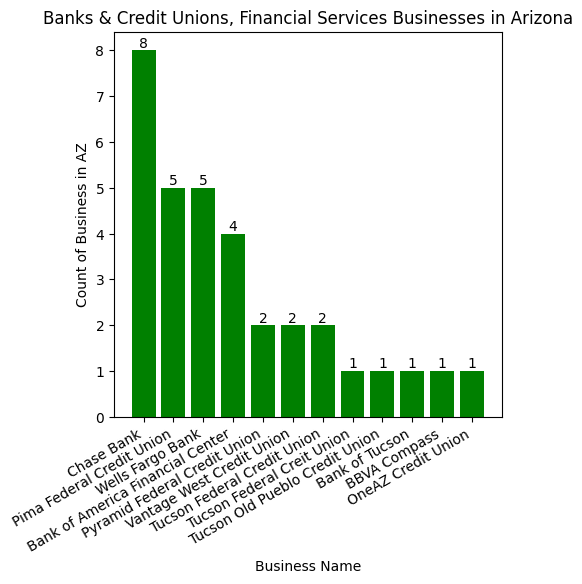

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize = (5,5))
bars = plt.bar(az_categories_df['name'],az_categories_df['total_count'],color = 'green')
plt.title("Banks & Credit Unions, Financial Services Businesses in Arizona")
plt.xlabel("Business Name")
plt.ylabel("Count of Business in AZ")
plt.xticks(ticks = range(len(az_categories_df["name"])), labels = az_categories_df['name'], rotation=30, ha = "right")

for bar,value in zip(bars, az_categories_df["total_count"]):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height(),
        f'{value}',
        ha='center',
        va='bottom'
    )
plt.show()


In [15]:
selected_category_df = spark.sql(f"select * from academic_dataset_az where categories == '{selected_category}'")
selected_category_df.createOrReplaceTempView("selected_category_df")


In [16]:
spark.sql("select name, count(stars) as total_ratings, round(sum(stars)/count(stars),2) as average_ratings from selected_category_df group by name order by average_ratings desc").show(truncate = False)

+--------------------------------+-------------+---------------+
|name                            |total_ratings|average_ratings|
+--------------------------------+-------------+---------------+
|Pyramid Federal Credit Union    |2            |3.5            |
|Pima Federal Credit Union       |5            |3.0            |
|Tucson Old Pueblo Credit Union  |1            |3.0            |
|Wells Fargo Bank                |5            |2.8            |
|Chase Bank                      |8            |2.69           |
|Bank of Tucson                  |1            |2.5            |
|BBVA Compass                    |1            |2.5            |
|OneAZ Credit Union              |1            |2.5            |
|Tucson Federal Creit Union      |1            |2.0            |
|Bank of America Financial Center|4            |1.88           |
|Vantage West Credit Union       |2            |1.75           |
|Tucson Federal Credit Union     |2            |1.25           |
+------------------------

In [17]:
!pip install -qq seaborn

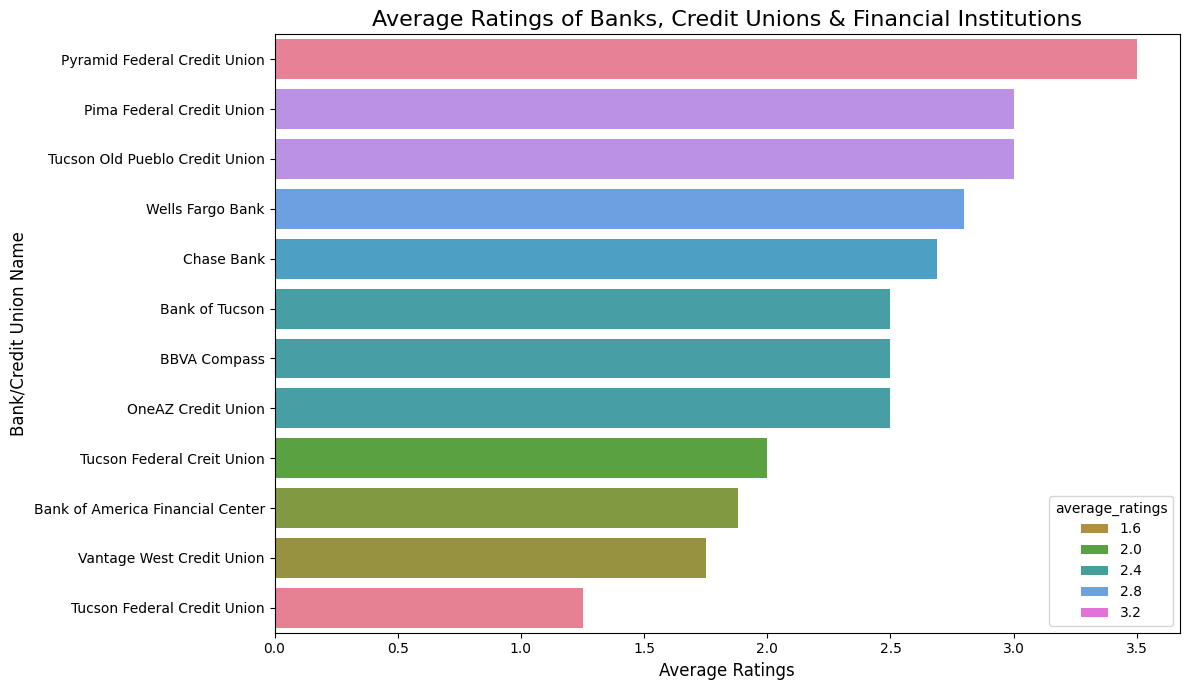

In [18]:
# Create a bar plot with a different color palette
import seaborn as sns
df = spark.sql("select name, round(sum(stars)/count(stars),2) as average_ratings from selected_category_df group by name order by average_ratings desc").toPandas()
plt.figure(figsize=(12, 7))
sns.barplot(x="average_ratings", y="name", data=df, palette="husl", hue = "average_ratings")

# Title and labels
plt.title('Average Ratings of Banks, Credit Unions & Financial Institutions', fontsize=16)
plt.xlabel('Average Ratings', fontsize=12)
plt.ylabel('Bank/Credit Union Name', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()


In [19]:
from pyspark.sql.functions import col
academic_dataset_joined = academic_dataset_parquet.alias("business").join(academic_dataset_review_parquet.alias("review"), academic_dataset_parquet.business_id == academic_dataset_review_parquet.business_id, "inner").select(
        col("business.address"),
        col("business.name"),
        col("business.business_id"),
        col("business.categories"),
        col("business.city"),
        col("business.stars"),
        col("business.state"),
        col("business.hours"),
        col("business.review_count"),
        col("review.review_id"),
        col("review.text"),
        col("review.funny"),
        col("review.cool"),
        col("review.useful"),
        col("review.user_id"),
        col("review.date"))

In [20]:
academic_dataset_joined.show()

+--------------------+--------------------+--------------------+--------------------+------------+-----+-----+--------------------+------------+--------------------+--------------------+-----+----+------+--------------------+-------------------+
|             address|                name|         business_id|          categories|        city|stars|state|               hours|review_count|           review_id|                text|funny|cool|useful|             user_id|               date|
+--------------------+--------------------+--------------------+--------------------+------------+-----+-----+--------------------+------------+--------------------+--------------------+-----+----+------+--------------------+-------------------+
|1809 South Parson...|Kojaks House of Ribs|znK6tMeegKf9YnGut...|Barbeque, Restaur...|     Seffner|  4.0|   FL|{11:0-22:0, null,...|         405|MmmrqbdupYBJq9jnl...|Great little spot...|    0|   0|     0|TjD2S66AWxlKsPSQB...|2021-04-16 22:02:21|
|               

In [21]:
academic_dataset_joined.createOrReplaceTempView("academic_dataset_joined")

In [22]:
academic_dataset_joined_selected_category = spark.sql("select * from academic_dataset_joined where state = 'AZ' and categories = 'Banks & Credit Unions, Financial Services'") 

In [23]:
academic_dataset_joined_selected_category.show()

+--------------------+--------------------+--------------------+--------------------+----------+-----+-----+--------------------+------------+--------------------+--------------------+-----+----+------+--------------------+-------------------+
|             address|                name|         business_id|          categories|      city|stars|state|               hours|review_count|           review_id|                text|funny|cool|useful|             user_id|               date|
+--------------------+--------------------+--------------------+--------------------+----------+-----+-----+--------------------+------------+--------------------+--------------------+-----+----+------+--------------------+-------------------+
|3755 W Cortaro Fa...|    Wells Fargo Bank|0Qqxm9SrGEi4qtfX0...|Banks & Credit Un...|    Tucson|  2.5|   AZ|{9:30-16:0, 9:30-...|           6|8WPi_bSfcZG8ano5B...|On June 28th my m...|    0|   0|     0|tQA7EE3aB9bgDPpIf...|2021-06-29 02:38:34|
|   10775 N Oracle Rd|Ba

In [24]:
academic_dataset_joined_selected_category.createOrReplaceTempView("academic_dataset_joined_selected_category")

In [25]:
spark.sql("select name, city, count(user_id) as total_users from academic_dataset_joined_selected_category group by name, city").show(truncate = False)

+--------------------------------+----------+-----------+
|name                            |city      |total_users|
+--------------------------------+----------+-----------+
|Bank of America Financial Center|Oro Valley|6          |
|Tucson Old Pueblo Credit Union  |Tucson    |6          |
|Wells Fargo Bank                |Tucson    |28         |
|Bank of America Financial Center|Tucson    |31         |
|Pima Federal Credit Union       |Tucson    |52         |
|Wells Fargo Bank                |Oro Valley|7          |
|Chase Bank                      |Tucson    |59         |
|Tucson Federal Creit Union      |Sahuarita |6          |
|Pyramid Federal Credit Union    |Tucson    |12         |
|Tucson Federal Credit Union     |Tucson    |16         |
|Vantage West Credit Union       |Tucson    |65         |
|BBVA Compass                    |Tucson    |6          |
|Pima Federal Credit Union       |Oro Valley|7          |
|OneAZ Credit Union              |Tucson    |17         |
|Bank of Tucso

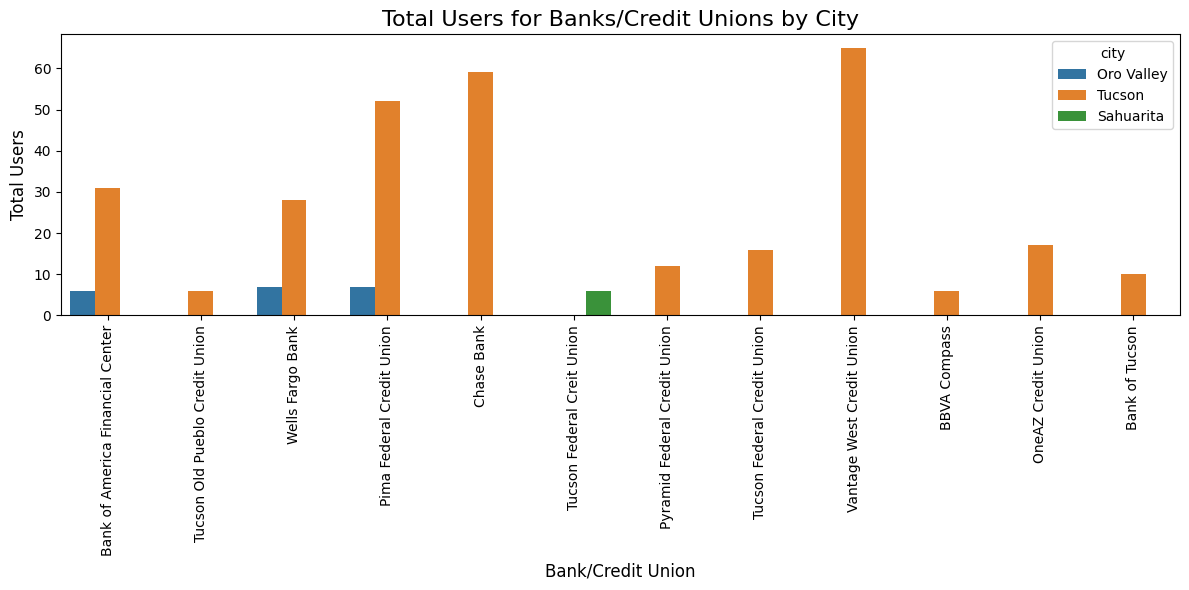

In [26]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
df = spark.sql("select name, city, count(user_id) as total_users from academic_dataset_joined_selected_category group by name, city").toPandas()
# Create a grouped bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='name', y='total_users', hue='city', data=df)

# Rotate x-axis labels to avoid overlap
plt.xticks(rotation=90)
plt.title('Total Users for Banks/Credit Unions by City', fontsize=16)
plt.xlabel('Bank/Credit Union', fontsize=12)
plt.ylabel('Total Users', fontsize=12)
plt.tight_layout()
plt.show()


In [27]:
spark.sql("select name, city, round(sum(stars)/count(stars),2) as average_ratings from academic_dataset_joined_selected_category group by name, city order by average_ratings desc").show(truncate = False)

+--------------------------------+----------+---------------+
|name                            |city      |average_ratings|
+--------------------------------+----------+---------------+
|Pima Federal Credit Union       |Oro Valley|4.5            |
|Pyramid Federal Credit Union    |Tucson    |3.67           |
|Wells Fargo Bank                |Oro Valley|3.5            |
|Tucson Old Pueblo Credit Union  |Tucson    |3.0            |
|Chase Bank                      |Tucson    |2.71           |
|Wells Fargo Bank                |Tucson    |2.61           |
|Bank of America Financial Center|Oro Valley|2.5            |
|BBVA Compass                    |Tucson    |2.5            |
|OneAZ Credit Union              |Tucson    |2.5            |
|Bank of Tucson                  |Tucson    |2.5            |
|Pima Federal Credit Union       |Tucson    |2.47           |
|Tucson Federal Creit Union      |Sahuarita |2.0            |
|Bank of America Financial Center|Tucson    |1.58           |
|Vantage

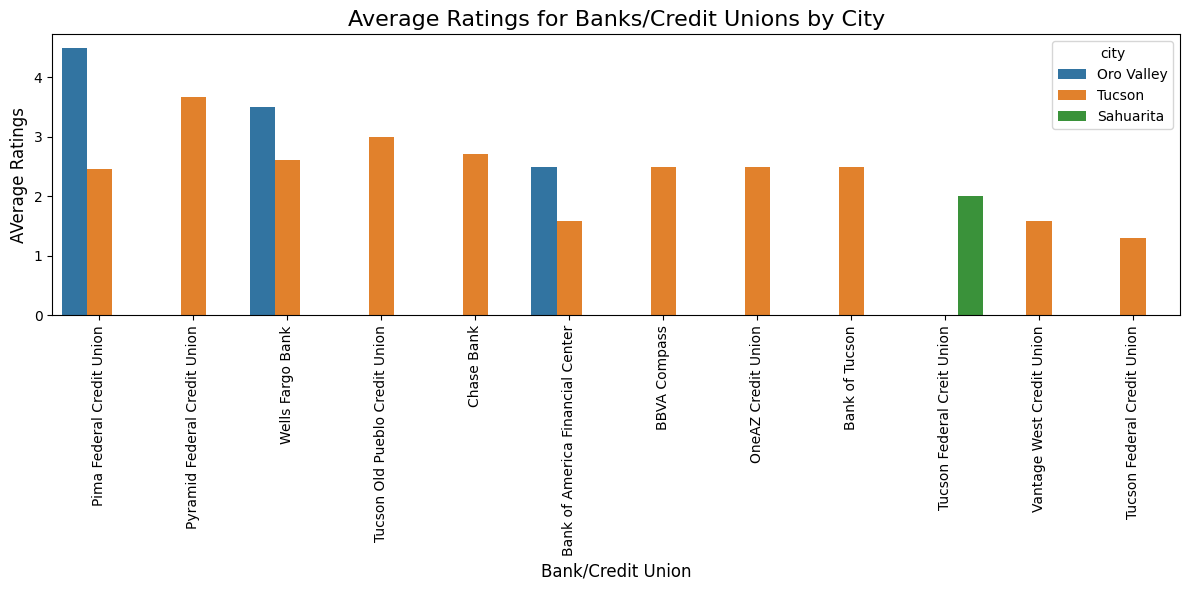

In [28]:
import plotly.express as px
df = spark.sql("select name, city, round(sum(stars)/count(stars),2) as average_ratings from academic_dataset_joined_selected_category group by name, city order by average_ratings desc").toPandas()
plt.figure(figsize=(12, 6))
sns.barplot(x='name', y='average_ratings', hue='city', data=df)
plt.xticks(rotation=90)
plt.title('Average Ratings for Banks/Credit Unions by City', fontsize=16)
plt.xlabel('Bank/Credit Union', fontsize=12)
plt.ylabel('AVerage Ratings', fontsize=12)

plt.tight_layout()
plt.show()

In [29]:
spark.sql("select city, sum(useful) as users_who_felt_reviews_useful, sum(review_count) as total_reviews, round(sum(useful)/sum(review_count),2) as user_helpfulness from academic_dataset_joined_selected_category group by city").show(truncate = False)

+----------+-----------------------------+-------------+----------------+
|city      |users_who_felt_reviews_useful|total_reviews|user_helpfulness|
+----------+-----------------------------+-------------+----------------+
|Tucson    |663                          |5150         |0.13            |
|Oro Valley|9                            |134          |0.07            |
|Sahuarita |4                            |30           |0.13            |
+----------+-----------------------------+-------------+----------------+



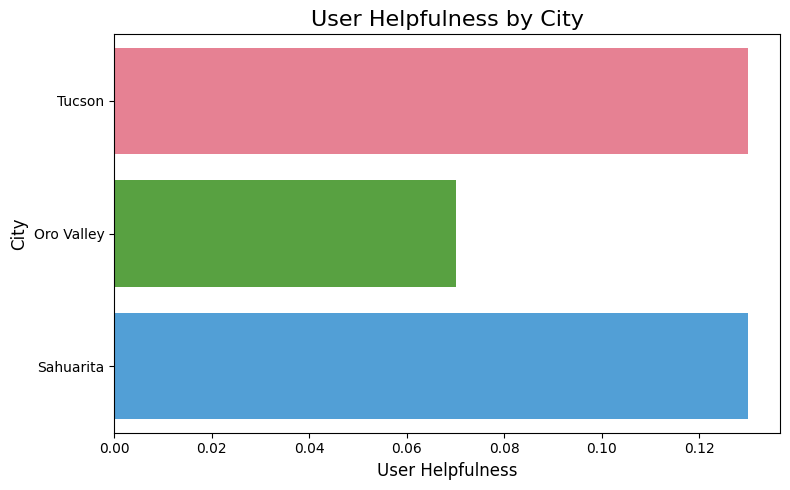

In [36]:
df = spark.sql("select city, sum(useful) as users_who_felt_reviews_useful, sum(review_count) as total_reviews, round(sum(useful)/sum(review_count),2) as user_helpfulness from academic_dataset_joined_selected_category group by city").toPandas()
plt.figure(figsize=(8, 5))
sns.barplot(x='user_helpfulness', y='city', data=df, palette="husl", hue = "city")
plt.title('User Helpfulness by City', fontsize=16)
plt.xlabel('User Helpfulness', fontsize=12)
plt.ylabel('City', fontsize=12)
plt.tight_layout()
plt.show()